Set up environment and load in data

In [1]:
library(tidyverse)
library(brms)
library(here)
library(grid)
library(gridExtra)
library(lemon)
theme_set(theme_bw())
helpers_path = paste0(here(),'/analysis/helpers/')
inputs_path = paste0(here(),'/inputs/')
source(paste0(helpers_path, '01_clean_behavioral_data.R'))
fig_out_path = paste0(here(), '/outputs/fig/')
rm(data_bc_clean)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Rcpp

Loading 'brms' package (version 2.19.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: 'brms'


The following object is masked from 'package:stats':

    ar


here() starts at /Users/zenkavi/Documents/RangelLab/NovelVsRepeated/behavior


Attaching package: 'gridExtra'


The following object is masked from 'package:dply

[1] "Done loading data."
[1] "Resetting helpers path..."


# Wrangling

In [2]:
data_yn_clean = data_yn_clean %>%
  mutate(correct = ifelse(possiblePayoff>reference & yesChosen == 1, 1, ifelse(possiblePayoff < reference & yesChosen == 0, 1, 0))) %>%
  mutate(type_chr = ifelse(type == 1, "Over Exposure", "Regular Exposure"),
         week = ifelse(week == 1, "Week 1", ifelse(week == 2, "Week 2", ifelse(week == 3, "Week 3", NA))),
         week = factor(week, levels = c("Week 1", "Week 2", "Week 3"))) %>%
  mutate(val_diff = possiblePayoff - reference,
         abs_val_diff = abs(possiblePayoff - reference),
         val_diff_bin = round(val_diff/50),
         val_diff_bin_str = paste0(val_diff_bin*50-25,":",val_diff_bin*50+25),
         val_diff_bin_str = factor(val_diff_bin_str, levels = c("-225:-175", "-175:-125", "-125:-75", "-75:-25", "-25:25", "25:75", "75:125", "125:175", "175:225")),
         time_bin = ifelse(day == 1, "Day 1", ifelse(day == 2, "Day 2", ifelse(day == 3, "Day 3", ifelse((day > 3) & (day < 8), "Week 2", "Week 3"))))) %>%
  mutate(subject = recode(subnum, 
                    `601` = "Subject 1", 
                    `609` = "Subject 2",
                    `611` = "Subject 3",
                    `619` = "Subject 4",
                    `621` = "Subject 5",
                    `629` = "Subject 6"))

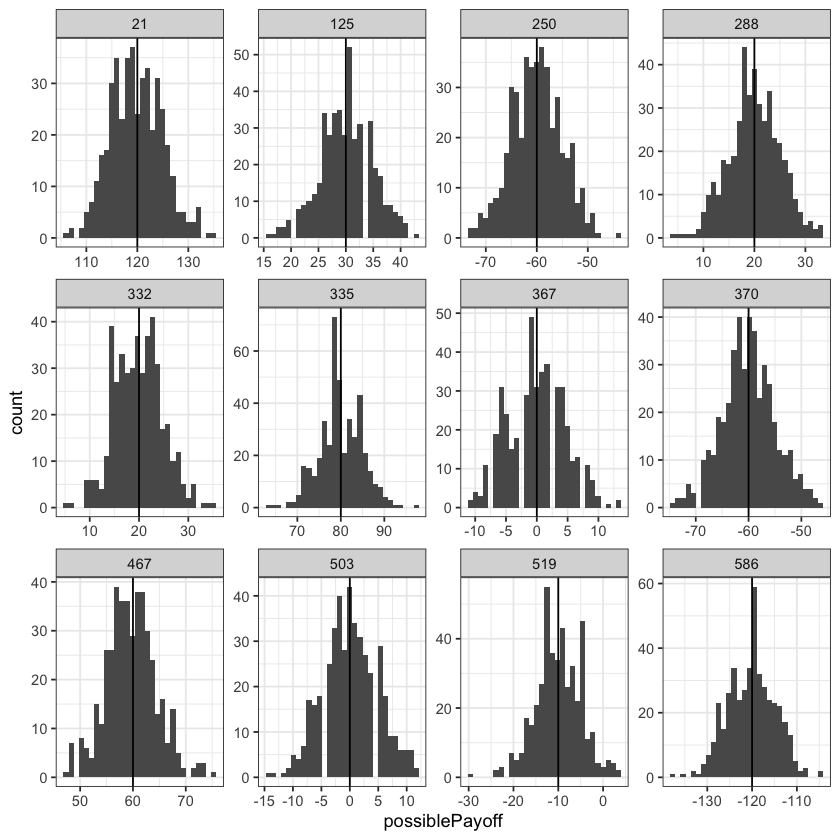

In [3]:
data_yn_clean %>%
  filter(subnum == 611 & type == 1) %>%
  mutate(trueVal = 100 * (valueO + valueF + valueS)/2) %>%
  ggplot(aes(possiblePayoff))+
  geom_histogram(bins = 30)+
  geom_vline(aes(xintercept = trueVal))+
  facet_wrap(~stimNum, scales = "free")

In [4]:
data_yn_clean %>%
  mutate(trueVal = round(100 * (valueO + valueF + valueS)/2) )%>%
  select(trueVal, possiblePayoff, val_diff, val_diff_bin_str)

trueVal,possiblePayoff,val_diff,val_diff_bin_str
<dbl>,<int>,<int>,<fct>
10,12,12,-25:25
-60,-60,-60,-75:-25
-100,-108,-108,-125:-75
60,57,57,25:75
-10,-9,-9,-25:25
0,3,3,-25:25
90,81,81,75:125
0,-2,-2,-25:25
10,21,21,-25:25


# Psychometrics

In [5]:
sub_summary = data_yn_clean %>%
  mutate(time_bin = ifelse(day == 1, "Day 1", ifelse(day == 2, "Day 2", ifelse(day == 3, "Day 3", ifelse((day > 3) & (day < 8), "Week 2", "Week 3")))),
         time_bin = factor(time_bin, levels = c("Week 3", "Week 2", "Week 1", "Day 3", "Day 2", "Day 1"))) %>%
  group_by(subject, time_bin, val_diff_bin_str, val_diff_bin, type_chr) %>%
  summarise(mean_y = mean(yesChosen),
            sem_y = sd(yesChosen)/sqrt(n()),
            .groups="keep") %>%
  mutate(val_diff_bin = val_diff_bin * 50) 

sub_summary

subject,time_bin,val_diff_bin_str,val_diff_bin,type_chr,mean_y,sem_y
<chr>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>
Subject 1,Week 3,-225:-175,-200,Regular Exposure,0.000000000,0.000000000
Subject 1,Week 3,-175:-125,-150,Over Exposure,0.000000000,0.000000000
Subject 1,Week 3,-175:-125,-150,Regular Exposure,0.000000000,0.000000000
Subject 1,Week 3,-125:-75,-100,Over Exposure,0.000000000,0.000000000
Subject 1,Week 3,-125:-75,-100,Regular Exposure,0.000000000,0.000000000
Subject 1,Week 3,-75:-25,-50,Over Exposure,0.008571429,0.004934517
Subject 1,Week 3,-75:-25,-50,Regular Exposure,0.007168459,0.005059741
Subject 1,Week 3,-25:25,0,Over Exposure,0.240484429,0.017791965
Subject 1,Week 3,-25:25,0,Regular Exposure,0.326732673,0.023363480


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


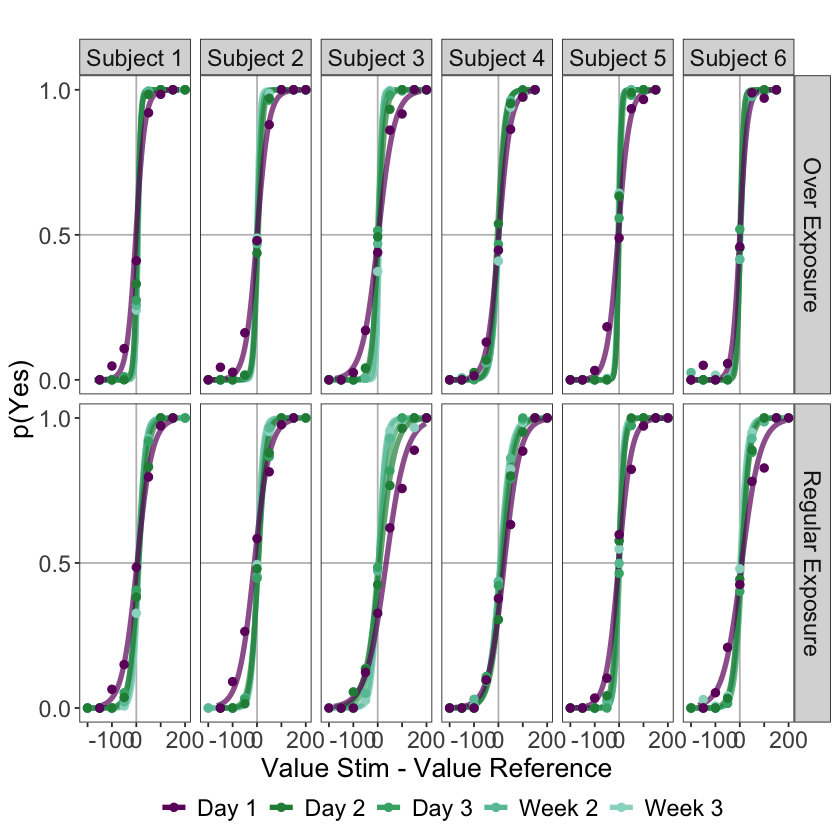

In [6]:
data_yn_clean%>%
  mutate(time_bin = factor(time_bin, levels = c("Week 3", "Week 2", "Week 1", "Day 3", "Day 2", "Day 1"))) %>%
  ggplot() +
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  geom_line(aes(val_diff, yesChosen, color = time_bin, alpha = time_bin), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, size = 1.5)+
  geom_point(data = sub_summary, aes(val_diff_bin, mean_y, color = time_bin), size = 2)+
  facet_grid(type_chr ~ subject)+
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76", "#66c2a4", "#99d8c9"),
                     breaks = c("Day 1", "Day 2", "Day 3", "Week 2", "Week 3"))+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))+
  guides(alpha = "none")

# ggsave(file=paste0(fig_out_path, 'isdn_yn_subj_pYesOverValDiffAcrossTime.jpg'), height = 5, width = 12, units="in")

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


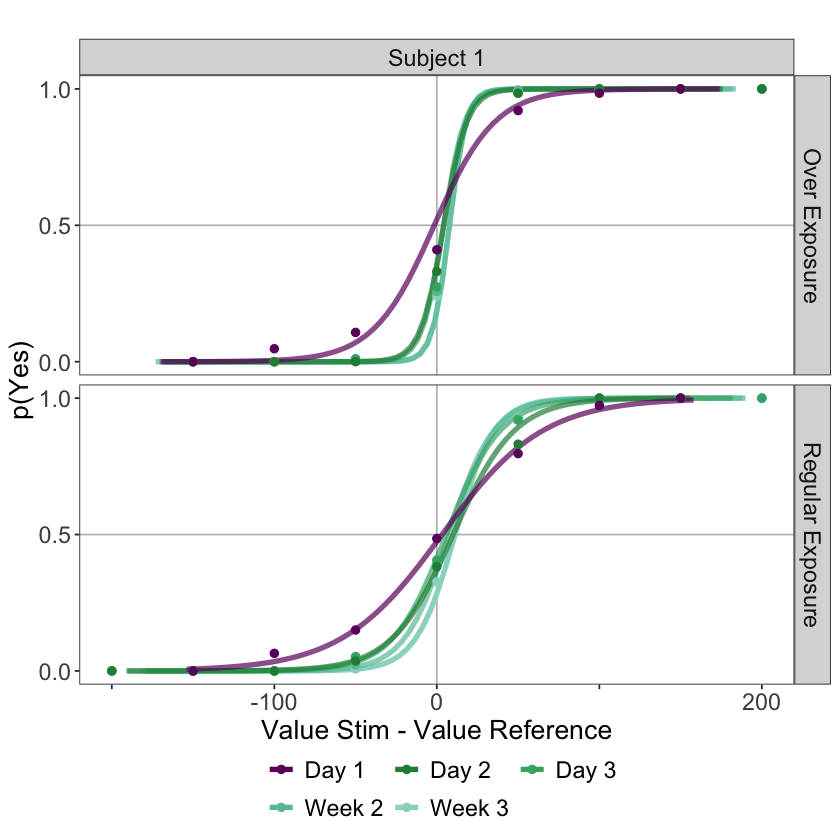

In [14]:
data_yn_clean %>%
  filter(subject == "Subject 1") %>%
  mutate(time_bin = factor(time_bin, levels = c("Week 3", "Week 2", "Week 1", "Day 3", "Day 2", "Day 1"))) %>%
  ggplot() +
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  geom_line(aes(val_diff, yesChosen, color = time_bin, alpha = time_bin), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, size = 1.5)+
  geom_point(data = sub_summary %>% filter(subject == "Subject 1"), aes(val_diff_bin, mean_y, color = time_bin), size = 2)+
  facet_grid(type_chr ~ subject)+
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
      #   legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  guides(color = guide_legend(nrow = 2, byrow = T)) +
  scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76", "#66c2a4", "#99d8c9"),
                     breaks = c("Day 1", "Day 2", "Day 3", "Week 2", "Week 3"))+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))+
  guides(alpha = "none")

  ggsave(file=paste0(fig_out_path, 'ccn_yn_Singlesubj_pYesOverValDiffAcrossTime.png'), height = 5, width = 4, units="in")

Plot the numerical value of the slopes and intercepts for each of these logits

In [15]:
k = length(unique(data_yn_clean$time_bin)) # number of factor levels

my_helmert = matrix(c(4/5, -1/5, -1/5, -1/5, -1/5,
                      0, 3/4, -1/4, -1/4, -1/4,
                      0, 0, 2/3, -1/3, -1/3,
                      0, 0, 0, 1/2, -1/2), ncol = k-1)

my_helmert

0.8,0.00,0.0000000,0.0
-0.2,0.75,0.0000000,0.0
-0.2,-0.25,0.6666667,0.0
-0.2,-0.25,-0.3333333,0.5
-0.2,-0.25,-0.3333333,-0.5


In [16]:
str(data_yn_clean$type)

 int [1:52600] 0 0 0 0 0 1 0 0 0 1 ...


In [17]:
str(as.factor(data_yn_clean$time_bin))

 Factor w/ 5 levels "Day 1","Day 2",..: 1 1 1 1 1 1 1 1 1 1 ...


In [18]:
fn_draws = paste0(inputs_path, 'yn_logit_norm_bydays_bytype_helmert_draws.csv')

if(file.exists(fn_draws)){
  yn_logit_draws = read.csv(fn_draws)
} else{
  subnums = unique(data_yn_clean$subnum)
  types = unique(data_yn_clean$type)
  normMax = 1
  normMinDay = 0
  normMinVal = -1
  
  yn_logit_draws = tibble()
  
  for(cur_sub in subnums){
    for(cur_type in types){
      cur_dat = data_yn_clean %>%
        ungroup() %>%
        filter(subnum == cur_sub & type == cur_type) %>%
        mutate(time_bin = as.factor(time_bin)) %>%
        group_by(day) %>% # Grouping by day to normalize valdiff matters. This makes sure every day ranges [-1,1]
        mutate(norm_valDiff = (normMax - normMinVal) / (max(val_diff) - min(val_diff)) * (val_diff - max(val_diff)) + (normMax)) %>%
        ungroup() %>%
        select(yesChosen, norm_valDiff, time_bin, type)
      
      contrasts(cur_dat$time_bin) = my_helmert
      
      cur_m <- brm(formula = yesChosen ~ norm_valDiff * time_bin,
                   data= cur_dat,
                   family = bernoulli(link = "logit"),
                   warmup = 500,
                   iter = 2500,
                   chains = 4,
                   init = "0",
                   cores = 4,
                   seed = 389253)
      
      cur_draws = as_draws_df(cur_m)
      cur_draws$subnum = cur_sub
      cur_draws$type = cur_type
      
      yn_logit_draws = rbind(yn_logit_draws, cur_draws) 
    }
  }
  names(yn_logit_draws) = gsub(":", ".", names(yn_logit_draws))
  write.csv(yn_logit_draws, fn_draws, row.names = F)
  
  rm(cur_dat, cur_m, cur_draws, cur_sub)
}


In [19]:
names(as_tibble(yn_logit_draws))[grepl("b_", names(as_tibble(yn_logit_draws)))]

[1] "b_Intercept"              "b_norm_valDiff"          
 [3] "b_time_bin1"              "b_time_bin2"             
 [5] "b_time_bin3"              "b_time_bin4"             
 [7] "b_norm_valDiff.time_bin1" "b_norm_valDiff.time_bin2"
 [9] "b_norm_valDiff.time_bin3" "b_norm_valDiff.time_bin4"

In [20]:
names(as_tibble(yn_logit_draws))

[1] "b_Intercept"              "b_norm_valDiff"          
 [3] "b_time_bin1"              "b_time_bin2"             
 [5] "b_time_bin3"              "b_time_bin4"             
 [7] "b_norm_valDiff.time_bin1" "b_norm_valDiff.time_bin2"
 [9] "b_norm_valDiff.time_bin3" "b_norm_valDiff.time_bin4"
[11] "lprior"                   "lp__"                    
[13] ".chain"                   ".iteration"              
[15] ".draw"                    "subnum"                  
[17] "type"

In [21]:
yn_par_summary = as_tibble(yn_logit_draws) %>%
  select(-lprior, -lp__, -.chain, -.iteration, -.draw) %>%
  gather(key, value, -subnum, -type) %>%
  mutate(key=recode(key, 
                    "b_Intercept" = "Intercept", 
                    "b_norm_valDiff"  = "Value Diff [-1, 1]",
                    "b_time_bin1" = "Day 1 vs Later",
                    "b_time_bin2" = "Day 2 vs Later",
                    "b_time_bin3" = "Day 3 vs Later",
                    "b_time_bin4" = "Week 2 vs Later",
                    "b_norm_valDiff.time_bin1" = "Value Diff x Day 1 vs Later",
                    "b_norm_valDiff.time_bin2" = "Value Diff x Day 2 vs Later",
                    "b_norm_valDiff.time_bin3" = "Value Diff x Day 3 vs Later",
                    "b_norm_valDiff.time_bin4" = "Value Diff x Week 2 vs Later",
                    ),
         key = factor(key, levels = c("Intercept", "Value Diff [-1, 1]", "Day 1 vs Later", "Day 2 vs Later", "Day 3 vs Later", "Week 2 vs Later", "Value Diff x Day 1 vs Later", "Value Diff x Day 2 vs Later", "Value Diff x Day 3 vs Later", "Value Diff x Week 2 vs Later"))) %>%
  group_by(subnum, type, key) %>%
  summarise(.groups = 'keep',
            m = mean(value),
            l95 = HDInterval::hdi(value)[1],
            h95 = HDInterval::hdi(value)[2]) %>%
  mutate(subnum = as.factor(subnum),
         task = "Y/N") 

In [22]:
yn_par_summary

subnum,type,key,m,l95,h95,task
<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<chr>
601,0,Intercept,-0.56745904,-0.71267888,-0.42143110,Y/N
601,0,"Value Diff [-1, 1]",10.32436630,9.49841231,11.15741798,Y/N
601,0,Day 1 vs Later,0.66232488,0.31818054,0.97961802,Y/N
601,0,Day 2 vs Later,-1.06035967,-1.56060371,-0.57613311,Y/N
601,0,Day 3 vs Later,0.24754101,-0.14669381,0.63986896,Y/N
601,0,Week 2 vs Later,0.06764879,-0.23740481,0.35233943,Y/N
601,0,Value Diff x Day 1 vs Later,-6.51681880,-7.93820843,-4.95333804,Y/N
601,0,Value Diff x Day 2 vs Later,-2.93610038,-5.20638037,-0.46619561,Y/N
601,0,Value Diff x Day 3 vs Later,-1.81982696,-4.53788679,0.88802249,Y/N


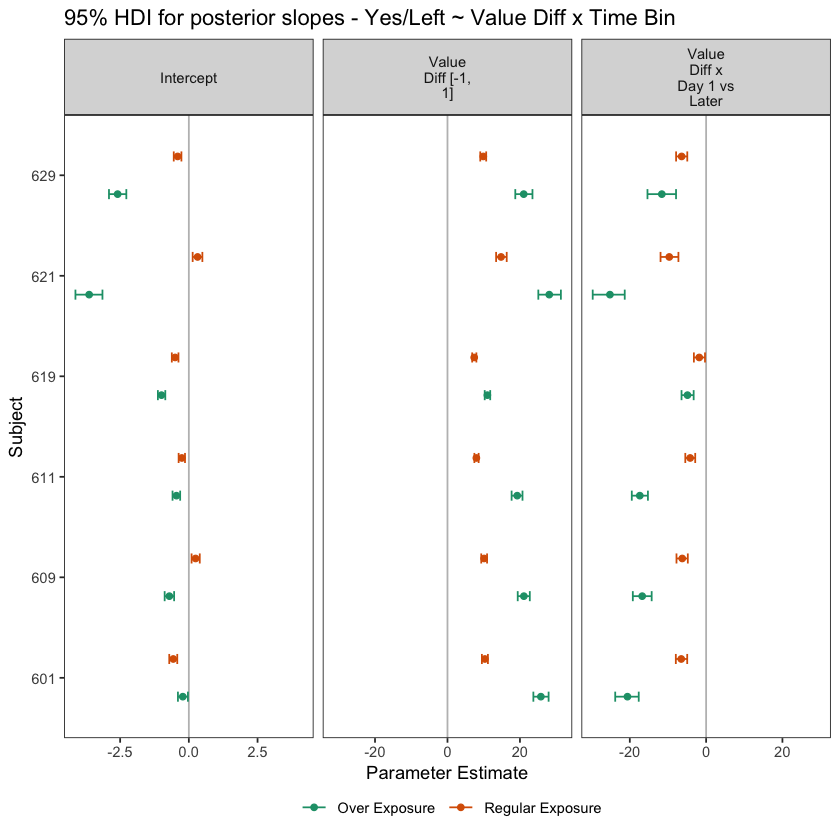

In [23]:
yn_par_summary %>%
  mutate(type_chr = ifelse(type == 0, "Regular Exposure", "Over Exposure")) %>%
  filter(key %in% c("Intercept", "Value Diff [-1, 1]", "Value Diff x Day 1 vs Later")) %>%
  ggplot(aes(m, subnum, color = type_chr)) +
  geom_vline(aes(xintercept = 0), color = "gray") + 
  geom_point(position = position_dodge(width=.75))+
  geom_errorbarh(aes(xmin = l95, xmax = h95, height=.2), position = position_dodge(width=.75))+
  facet_wrap(~key, scales = 'free_x',labeller = labeller(key = label_wrap_gen(10))) +
  labs(x = "Parameter Estimate", y = "Subject", color = "", title = "95% HDI for posterior slopes - Yes/Left ~ Value Diff x Time Bin") +
  theme(legend.position = "bottom",
        panel.grid = element_blank(),
        legend.box.margin=margin(t = -10))+
  scale_x_symmetric(mid=0)+
  scale_color_brewer(palette = "Dark2")

# RT

In [24]:
data_yn_clean = data_yn_clean %>%
  mutate(abs_val_diff_bin_str =  paste0(abs(val_diff_bin)*50-25,":",abs(val_diff_bin)*50+25),
         abs_val_diff_bin_str = ifelse(abs_val_diff_bin_str ==  "-25:25", "0:25", abs_val_diff_bin_str),
         abs_val_diff_bin_str = factor(abs_val_diff_bin_str, levels = c("0:25", "25:75", "75:125", "125:175", "175:225", "225:275")))

In [25]:
sub_summary = data_yn_clean %>%
  group_by(subject, time_bin, abs_val_diff_bin_str, type_chr) %>%
  summarise(mean_y = mean(log(rt)),
            .groups="keep") %>%
  mutate(mean_rt = exp(mean_y), 
         abs_val_diff = (as.numeric(abs_val_diff_bin_str) - 1) * 50)

sub_summary

subject,time_bin,abs_val_diff_bin_str,type_chr,mean_y,mean_rt,abs_val_diff
<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
Subject 1,Day 1,0:25,Over Exposure,0.09428144,1.0988690,0
Subject 1,Day 1,0:25,Regular Exposure,0.23572379,1.2658246,0
Subject 1,Day 1,25:75,Over Exposure,-0.04292748,0.9579809,50
Subject 1,Day 1,25:75,Regular Exposure,0.11908136,1.1264616,50
Subject 1,Day 1,75:125,Over Exposure,-0.16719532,0.8460343,100
Subject 1,Day 1,75:125,Regular Exposure,-0.06701547,0.9351807,100
Subject 1,Day 1,125:175,Over Exposure,-0.33189436,0.7175631,150
Subject 1,Day 1,125:175,Regular Exposure,-0.20661964,0.8133289,150
Subject 1,Day 2,0:25,Over Exposure,0.05937332,1.0611713,0


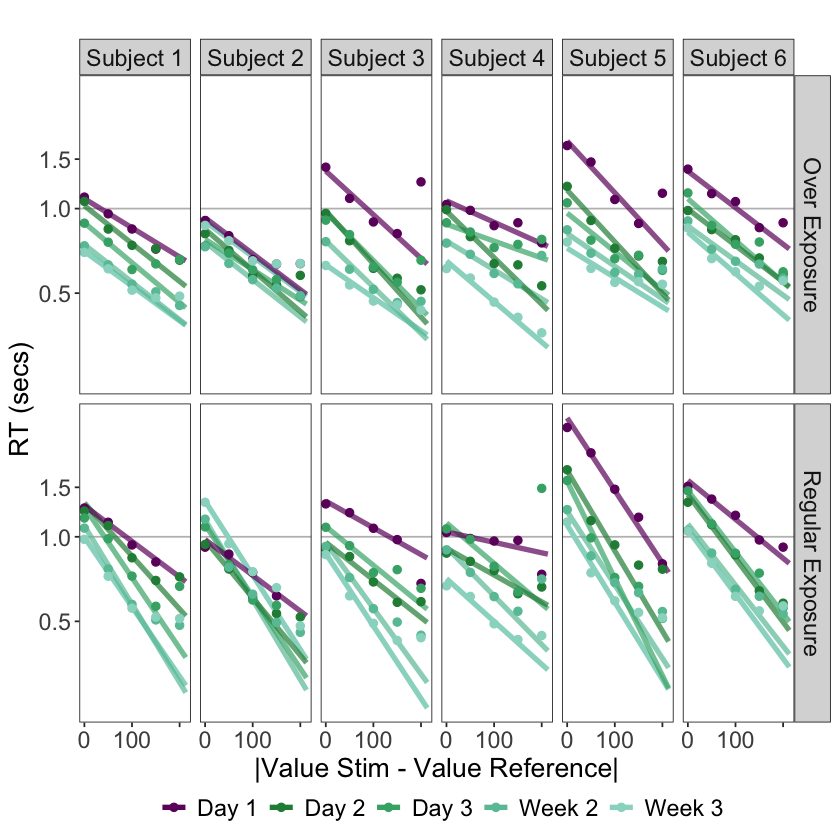

In [26]:
data_yn_clean %>%
  mutate(time_bin = factor(time_bin, levels = c("Week 3", "Week 2", "Week 1", "Day 3", "Day 2", "Day 1"))) %>%
  ggplot() +
  geom_hline(aes(yintercept = 1), color = "gray") +
  geom_line(aes(abs_val_diff, rt, color = time_bin, alpha = time_bin), stat="smooth", method = "lm", formula = "y ~ x", se = FALSE, linewidth = 1.5, fullrange = TRUE)+
  geom_point(data = sub_summary, aes(abs_val_diff, mean_rt, color = time_bin), size = 2)+
  facet_grid(type_chr ~ subject)+
  labs(x = "|Value Stim - Value Reference|", y = "RT (secs)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76", "#66c2a4", "#99d8c9"),
                     breaks = c("Day 1", "Day 2", "Day 3", "Week 2", "Week 3"))+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  scale_y_continuous(trans = "log", breaks = c(0.1, .5, 1, 1.5))+
  scale_x_continuous(breaks = c(0, 100, 200),
                     labels = c("0", "100", ""))+
  guides(alpha = "none")

# ggsave(file=paste0(fig_out_path, 'isdn_yn_subj_RTOverValDiffAcrossTime.jpg'), height = 5, width = 12, units="in")

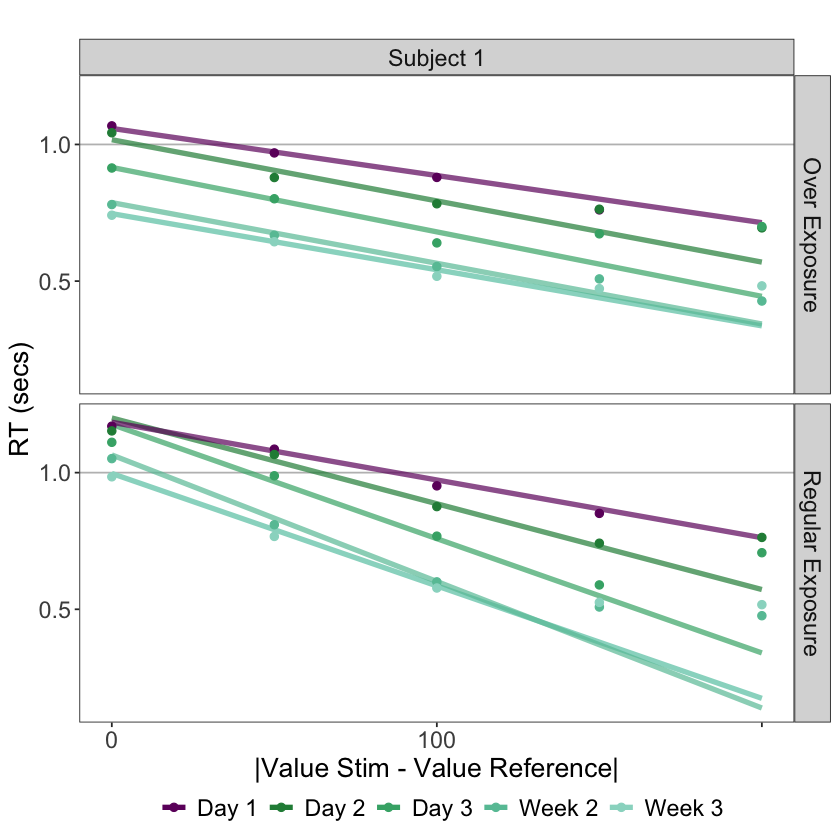

In [28]:
data_yn_clean %>%
  filter(subject == "Subject 1") %>%
  mutate(time_bin = factor(time_bin, levels = c("Week 3", "Week 2", "Week 1", "Day 3", "Day 2", "Day 1"))) %>%
  ggplot() +
  geom_hline(aes(yintercept = 1), color = "gray") +
  geom_line(aes(abs_val_diff, rt, color = time_bin, alpha = time_bin), stat="smooth", method = "lm", formula = "y ~ x", se = FALSE, linewidth = 1.5, fullrange = TRUE)+
  geom_point(data = sub_summary %>% filter(subject == "Subject 1"), aes(abs_val_diff, mean_rt, color = time_bin), size = 2)+
  facet_grid(type_chr ~ subject)+
  labs(x = "|Value Stim - Value Reference|", y = "RT (secs)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        # legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  guides(color = guide_legend(nrow = 2, byrow = T)) +
  scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76", "#66c2a4", "#99d8c9"),
                     breaks = c("Day 1", "Day 2", "Day 3", "Week 2", "Week 3"))+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  scale_y_continuous(trans = "log", breaks = c(0.1, .5, 1, 1.5))+
  scale_x_continuous(breaks = c(0, 100, 200),
                     labels = c("0", "100", ""))+
  guides(alpha = "none")

ggsave(file=paste0(fig_out_path, 'ccn_yn_Singlesubj_RTOverValDiffAcrossTime.jpg'), height = 5, width = 4, units="in")

Comparison of types across time bins

In [ ]:
data_yn_clean %>%
  mutate(time_bin = factor(time_bin, levels = c("Week 3", "Week 2", "Week 1", "Day 3", "Day 2", "Day 1"))) %>%
  ggplot() +
  geom_line(aes(abs_val_diff, rt, color = type_chr), stat="smooth", method = "lm", formula = "y ~ x", se = FALSE, size = 1.5)+
  geom_point(data = sub_summary, aes(abs_val_diff, mean_rt, color = type_chr), size = 2)+
  facet_grid(time_bin ~ subject)+
  labs(x = "|Value Stim - Value Reference|", y = "RT (secs)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_brewer(palette = "Dark2")+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  scale_y_continuous(trans = "log", breaks = c(0.1, .5, 1, 1.5))+
  scale_x_continuous(breaks = c(0, 100, 200),
                     labels = c("0", "100", ""))

Helmert coding: Compare day 1 to later, day 2 to later etc. 

In [ ]:
k = length(unique(data_yn_clean$time_bin)) # number of factor levels

my_helmert = matrix(c(4/5, -1/5, -1/5, -1/5, -1/5,
                      0, 3/4, -1/4, -1/4, -1/4,
                      0, 0, 2/3, -1/3, -1/3,
                      0, 0, 0, 1/2, -1/2), ncol = k-1)
  
my_helmert

In [ ]:
fn_draws = paste0(inputs_path, 'yn_rt_norm_bydays_bytype_helmert_draws.csv')

if(file.exists(fn_draws)){
  yn_rt_draws = read.csv(fn_draws)
} else{
  subnums = unique(data_yn_clean$subnum)
  types = unique(data_yn_clean$type)
  normMax = 1
  normMin = 0
  
  yn_rt_draws = tibble()

  for(cur_sub in subnums){
    for(cur_type in types){
      cur_dat = data_yn_clean %>% 
        ungroup() %>%
        filter(subnum == cur_sub & type == cur_type) %>%
        mutate(time_bin = as.factor(time_bin)) %>%
        mutate(log_rt = log(rt)) %>%
        group_by(day) %>% # Grouping by day to normalize valdiff matters. This makes sure every day ranges [-1,1]
        mutate(norm_absValDiff = (normMax - normMin) / (max(abs_val_diff) - min(abs_val_diff)) * (abs_val_diff - max(abs_val_diff)) + (normMax)) %>%
        ungroup() %>%
        select(log_rt, norm_absValDiff, time_bin, type)
      
      contrasts(cur_dat$time_bin) = my_helmert
      
      cur_m <- brm(formula = log_rt ~ norm_absValDiff * time_bin,
                   data= cur_dat,
                   warmup = 500,
                   iter = 2500,
                   chains = 4,
                   init = "0",
                   cores = 4,
                   seed = 389253)
      
      cur_draws = as_draws_df(cur_m)
      cur_draws$subnum = cur_sub
      cur_draws$type = cur_type
      
      yn_rt_draws = rbind(yn_rt_draws, cur_draws) 
    }
  }
  names(yn_rt_draws) = gsub(":", ".", names(yn_rt_draws))
  write.csv(yn_rt_draws, fn_draws, row.names = F)

  rm(cur_dat, cur_m, cur_draws, cur_sub)
}


In [ ]:
names(as_tibble(yn_rt_draws))[grepl("b_", names(as_tibble(yn_rt_draws)))]

In [ ]:
names(as_tibble(yn_rt_draws))

In [ ]:
yn_par_summary = as_tibble(yn_rt_draws) %>%
  select(-lprior, -lp__, -.chain, -.iteration, -.draw, -sigma) %>%
  gather(key, value, -subnum, -type) %>%
  mutate(key=recode(key, 
                    "b_Intercept" = "Intercept", 
                    "b_norm_absValDiff"  = "|Value Diff| [0, 1]",
                    "b_time_bin1" = "Day 1 vs Later",
                    "b_time_bin2" = "Day 2 vs Later",
                    "b_time_bin3" = "Day 3 vs Later",
                    "b_time_bin4" = "Week 2 vs Later",
                    "b_norm_absValDiff.time_bin1" = "Value Diff x Day 1 vs Later",
                    "b_norm_absValDiff.time_bin2" = "Value Diff x Day 2 vs Later",
                    "b_norm_absValDiff.time_bin3" = "Value Diff x Day 3 vs Later",
                    "b_norm_absValDiff.time_bin4" = "Value Diff x Week 2 vs Later",
                    ),
         key = factor(key, levels = c("Intercept", "|Value Diff| [0, 1]", "Day 1 vs Later", "Day 2 vs Later", "Day 3 vs Later", "Week 2 vs Later", "Value Diff x Day 1 vs Later", "Value Diff x Day 2 vs Later", "Value Diff x Day 3 vs Later", "Value Diff x Week 2 vs Later"))) %>%
  group_by(subnum, type, key) %>%
  summarise(.groups = 'keep',
            m = mean(value),
            l95 = HDInterval::hdi(value)[1],
            h95 = HDInterval::hdi(value)[2]) %>%
  mutate(subnum = as.factor(subnum),
         task = "Y/N") 

In [ ]:
yn_par_summary

In [ ]:
yn_par_summary %>%
  mutate(type_chr = ifelse(type == 0, "Regular Exposure", "Over Exposure")) %>%
  filter(key %in% c("Intercept", "|Value Diff| [0, 1]", "Value Diff x Day 1 vs Later")) %>%
  ggplot(aes(m, subnum, color = type_chr)) +
  geom_vline(aes(xintercept = 0), color = "gray") + 
  geom_point(position = position_dodge(width=.75))+
  geom_errorbarh(aes(xmin = l95, xmax = h95, height=.2), position = position_dodge(width=.75))+
  facet_wrap(~key, scales = 'free_x',labeller = labeller(key = label_wrap_gen(10))) +
  labs(x = "Parameter Estimate", y = "Subject", color = "", title = "95% HDI for posterior slopes - Yes/Left ~ Value Diff x Time Bin") +
  theme(legend.position = "bottom",
        panel.grid = element_blank(),
        legend.box.margin=margin(t = -10))+
  scale_x_symmetric(mid=0)+
  scale_color_brewer(palette = "Dark2")

# Reference amount

## Choice

Are you more likely to say yes/no to a stimulus with the same value difference depending on the reference amount?

Does this change over days?

In [ ]:
data_yn_clean%>%
  mutate(time_bin = factor(time_bin, levels = c("Week 3", "Week 2", "Week 1", "Day 3", "Day 2", "Day 1")),
         reference = factor(reference, levels = c(-50, 0, 50)),
         day1 = ifelse(day == 1, "Day 1", "Later"),
         day1 = as.factor(day1)) %>%
  ggplot() +
  geom_line(aes(val_diff, yesChosen, color = reference), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, size = 1.5, fullrange = T)+
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  facet_grid(type_chr ~ day1)+
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
   scale_color_manual(values = c("#ca0020", "dark grey", "#0571b0"))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))

# ggsave(file=paste0(fig_out_path, 'isdn_yn_subj_LogitRefEffects.jpg'), height = 5, width = 6, units="in")

In [ ]:
data_yn_clean%>%
  mutate(time_bin = factor(time_bin, levels = c("Week 3", "Week 2", "Week 1", "Day 3", "Day 2", "Day 1")),
         reference = factor(reference, levels = c(-50, 0, 50)),
         day1 = ifelse(day == 1, "Day 1", "Later"),
         day1 = as.factor(day1)) %>%
  filter(day == 1) %>%
  ggplot() +
  geom_line(aes(val_diff, yesChosen, color = reference), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, size = 1.5, fullrange = T)+
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  facet_grid(type_chr ~ subnum)+
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
   scale_color_manual(values = c("#ca0020", "dark grey", "#0571b0"))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))

In [ ]:
data_yn_clean%>%
  mutate(time_bin = factor(time_bin, levels = c("Week 3", "Week 2", "Week 1", "Day 3", "Day 2", "Day 1")),
         reference = factor(reference, levels = c(-50, 0, 50)),
         day1 = ifelse(day == 1, "Day 1", "Later"),
         day1 = as.factor(day1)) %>%
  filter(day != 1) %>%
  ggplot() +
  geom_line(aes(val_diff, yesChosen, color = reference), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, size = 1.5, fullrange = T)+
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  facet_grid(type_chr ~ subnum)+
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
   scale_color_manual(values = c("#ca0020", "dark grey", "#0571b0"))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))

In [ ]:
cur_dat = data_yn_clean %>%
  mutate(reference = factor(reference, levels = c(0, -50, 50))) %>%
  group_by(subnum, type, day) %>%
  mutate(norm_valDiff = (normMax - normMinVal) / (max(val_diff) - min(val_diff)) * (val_diff - max(val_diff)) + (normMax))

cur_m <- brm(formula = yesChosen ~ (1 | reference * type),
             data= cur_dat,
             family = bernoulli(link = "logit"),
             warmup = 500,
             iter = 2500,
             chains = 4,
             init = "0",
             cores = 4,
             seed = 389253)

In [ ]:
m1 = lme4::glmer(yesChosen ~ (1 | subnum) + (1 | reference) + norm_valDiff, data= cur_dat %>% filter(type==1), family = binomial(link = "logit"))

m0 = lme4::glmer(yesChosen ~ (1 | subnum) + (1 | reference) + norm_valDiff, data= cur_dat %>% filter(type==0), family = binomial(link = "logit"))

In [ ]:
summary(m1)
ranef(m1)

In [ ]:
summary(m0)
ranef(m0)

In [ ]:
m = lme4::glmer(yesChosen ~ (1 | subnum:reference) + norm_valDiff, data= cur_dat %>% filter(type==1), family = binomial(link = "logit"))

In [ ]:
summary(m)
ranef(m)

In [ ]:
ranef(m1)
ranef(m0)

Random intercept model in brms was taking too long.

## RT

In [ ]:
data_yn_clean %>%
  mutate(time_bin = factor(time_bin, levels = c("Week 3", "Week 2", "Week 1", "Day 3", "Day 2", "Day 1")),
         reference = factor(reference, levels = c(-50, 0, 50)),
         day1 = ifelse(day == 1, "Day 1", "Later"),
         day1 = as.factor(day1)) %>%
  ggplot() +
  geom_line(aes(abs_val_diff, rt, color = reference), stat="smooth", method = "lm", formula = "y ~ x", se = FALSE, size = 1.5)+
  facet_grid(type_chr ~ day1)+
  labs(x = "|Value Stim - Value Reference|", y = "RT (secs)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_manual(values = c("#ca0020", "dark grey", "#0571b0"))+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  scale_y_continuous(trans = "log", breaks = c(0.1, .5, 1, 1.5))+
  scale_x_continuous(breaks = c(0, 100, 200),
                     labels = c("0", "100", ""))

# ggsave(file=paste0(fig_out_path, 'isdn_yn_subj_RTRefEffects.jpg'), height = 5, width = 6, units="in")

# HT on day 1

````{r warning=FALSE}
data_yn_clean %>%
  filter(subnum == 619) %>%
  ggplot() +
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  geom_line(aes(val_diff, yesChosen, color = type_chr), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, size = 1.5, fullrange = T) +
  facet_grid(time_bin ~ session) +
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_brewer(palette = "Dark2")+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))

```

In [ ]:
data_yn_clean %>%
  filter(subnum == 619) %>%
  # mutate(time_bin = factor(time_bin, levels = c("Week 3", "Week 2", "Week 1", "Day 3", "Day 2", "Day 1"))) %>%
  ggplot() +
  geom_line(aes(abs_val_diff, rt, color = type_chr), stat="smooth", method = "lm", formula = "y ~ x", se = FALSE, size = 1.5)+
  facet_grid(time_bin ~ session) +
  labs(x = "|Value Stim - Value Reference|", y = "RT (secs)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_brewer(palette = "Dark2")+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  scale_y_continuous(trans = "log", breaks = c(0.1, .5, 1, 1.5))+
  scale_x_continuous(breaks = c(0, 100, 200),
                     labels = c("0", "100", ""))

# RLDDM

What is the interesting question here? "Are you learning about the HT in an isolated manner? Or is what you have learned about them leaking to other stims in some way?"  

This is a bit of a straw man argument. If there was no generalization there would be no reason for behavior in RE to improve. So there is learning for more than just the stim value but what is the representation that is being updated?

In [ ]:
source(paste0(helpers_path, "rlddm/yn_rlddm.R"))

## Model all days with same parameters

In [ ]:
cur_subnum = 601
cur_day = c(1, 2, 3)
stims = data_yn_clean %>% filter(subnum == cur_subnum & day %in% cur_day)

Takes ~ 18 seconds with these parameters (`d = .005, sigma = .005, alpha = .3, theta = .2`) for 800 trials.

In [ ]:
sim_data = sim_task(stims, d = .003, sigma = .09, alpha = .001, theta = 0, k = .15, nonDecisionTime = 300, bias = 0, barrierDecay = 0, return_values = TRUE)

Plot: heat map of value representations with number of occurence of each attribute level
Normalize values to range from [-1 to +1]

In [ ]:
occs = stims %>%
  count(orientation) %>%
  rename(attr_level = orientation) %>%
  mutate(attr = "orientation") %>%
  rbind(stims %>%
          count(shape) %>%
          rename(attr_level = shape) %>%
          mutate(attr = "shape")) %>%
  rbind(stims %>%
          count(filling) %>%
          rename(attr_level = filling) %>%
          mutate(attr = "filling")) %>%
  mutate( attr_level = as.factor(attr_level))

In [ ]:
true_vals = data_yn_clean %>%
  filter(subnum == cur_subnum) %>%
  select(valueS, shape) %>%
  distinct() %>%
  rename(val = valueS, attr_level = shape) %>%
  mutate(attr = "shape") %>%
  rbind(data_yn_clean %>%
          filter(subnum == cur_subnum) %>%
          select(valueF, filling) %>%
          distinct() %>%
          rename(val = valueF, attr_level = filling) %>%
          group_by(attr_level) %>%
          summarise(val = mean(val)) %>%
          mutate(attr = "filling")) %>%
  rbind(data_yn_clean %>%
          filter(subnum == cur_subnum) %>%
          select(valueO, orientation) %>%
          distinct() %>%
          rename(val = valueO, attr_level = orientation) %>%
          mutate(attr = "orientation")) %>%
  mutate(y = 1, type = "true",
         attr_level = as.factor(attr_level))


In [ ]:
normMax = 1
normMin = -1

sim_vals = tibble(attr_level = factor(1:6), val = sim_data$values$val_shape) %>%
  mutate(attr = "shape", type = "sim") %>%
  rbind(tibble(attr_level = factor(c(-.85, -.6, -.4, -.2, 0, .2, .4, .6, .85)), val = sim_data$values$val_filling) %>%
          mutate(attr = "filling", type = "sim")) %>%
  rbind(tibble(attr_level = factor(seq(0,150, 15)), val = sim_data$values$val_orientation) %>%
          mutate(attr = "orientation", type = "sim")) %>%
  group_by(attr) %>%
  mutate(val = (normMax - normMin) / (max(val) - min(val)) * (val - max(val)) + (normMax),
         y = factor(1)) 

In [ ]:
true_vals %>%
  rbind(sim_vals) %>%
  left_join(occs, by = c("attr", "attr_level")) %>%
  ggplot(aes(attr_level, y, fill = val)) +
  geom_tile()+
  geom_text(aes(label = n), size = 2, nudge_y = .4) +
  theme(panel.grid = element_blank(),
        panel.border = element_blank(),
        legend.position = "bottom",
        legend.box.margin=margin(t = -30),
        axis.ticks = element_blank(),
        axis.text = element_blank())+
  facet_grid(type~attr, scales = "free")+
  labs(y = "", x = "", fill = "")+
  scale_fill_gradient2(low = "#b2182b", high = "#2166ac", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab")

In [ ]:
sim_vals_d1 = tibble(attr_level = factor(1:6), val = sim_data$out$val_shape[800][[1]]) %>%
  mutate(attr = "shape", type = "sim_d1") %>%
  rbind(tibble(attr_level = factor(c(-.85, -.6, -.4, -.2, 0, .2, .4, .6, .85)), val = sim_data$out$val_filling[800][[1]]) %>%
          mutate(attr = "filling", type = "sim_d1")) %>%
  rbind(tibble(attr_level = factor(seq(0,150, 15)), val = sim_data$out$val_orientation[800][[1]]) %>%
          mutate(attr = "orientation", type = "sim_d1")) %>%
  group_by(attr) %>%
  mutate(val = (normMax - normMin) / (max(val) - min(val)) * (val - max(val)) + (normMax),
         y = factor(1)) 

sim_vals_d2 = tibble(attr_level = factor(1:6), val = sim_data$out$val_shape[2*800][[1]]) %>%
  mutate(attr = "shape", type = "sim_d2") %>%
  rbind(tibble(attr_level = factor(c(-.85, -.6, -.4, -.2, 0, .2, .4, .6, .85)), val = sim_data$out$val_filling[2*800][[1]]) %>%
          mutate(attr = "filling", type = "sim_d2")) %>%
  rbind(tibble(attr_level = factor(seq(0,150, 15)), val = sim_data$out$val_orientation[2*800][[1]]) %>%
          mutate(attr = "orientation", type = "sim_d2")) %>%
  group_by(attr) %>%
  mutate(val = (normMax - normMin) / (max(val) - min(val)) * (val - max(val)) + (normMax),
         y = factor(1)) 

sim_vals_d3 = tibble(attr_level = factor(1:6), val = sim_data$out$val_shape[3*800][[1]]) %>%
  mutate(attr = "shape", type = "sim_d3") %>%
  rbind(tibble(attr_level = factor(c(-.85, -.6, -.4, -.2, 0, .2, .4, .6, .85)), val = sim_data$out$val_filling[3*800][[1]]) %>%
          mutate(attr = "filling", type = "sim_d3")) %>%
  rbind(tibble(attr_level = factor(seq(0,150, 15)), val = sim_data$out$val_orientation[3*800][[1]]) %>%
          mutate(attr = "orientation", type = "sim_d3")) %>%
  group_by(attr) %>%
  mutate(val = (normMax - normMin) / (max(val) - min(val)) * (val - max(val)) + (normMax),
         y = factor(1)) 

In [ ]:
sim_vals_d1

In [ ]:
true_vals %>%
  rbind(sim_vals_d1, sim_vals_d2, sim_vals_d3) %>%
  # left_join(occs, by = c("attr", "attr_level")) %>%
  ggplot(aes(attr_level, y, fill = val)) +
  geom_tile()+
  # geom_text(aes(label = n), size = 2, nudge_y = .4) +
  theme(panel.grid = element_blank(),
        panel.border = element_blank(),
        legend.position = "bottom",
        legend.box.margin=margin(t = -30),
        axis.ticks = element_blank(),
        axis.text = element_blank())+
  facet_grid(type~attr, scales = "free")+
  labs(y = "", x = "", fill = "")+
  scale_fill_gradient2(low = "#b2182b", high = "#2166ac", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab")

In [ ]:
sim_data$out = sim_data$out %>%
  # filter(type == 1) %>%
  mutate(type_chr = ifelse(type == 1, "Over Exposure", "Regular Exposure"),
         val_diff = possiblePayoff - reference,
         abs_val_diff = abs(possiblePayoff - reference),
         val_diff_bin = round(val_diff/50),
         val_diff_bin_str = paste0(val_diff_bin*50-25,":",val_diff_bin*50+25),
         val_diff_bin_str = factor(val_diff_bin_str, levels = c("-225:-175", "-175:-125", "-125:-75", "-75:-25", "-25:25", "25:75", "75:125", "125:175", "175:225")),
         yesChosen = ifelse(choice == "yes", 1, 0)) %>%
    mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 1", "Day 2", "Day 3")))


In [ ]:
sim_data$out %>%
  ggplot()+
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  geom_line(aes(val_diff, yesChosen, color = type_chr), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, linewidth = 1.5, fullrange = T) +
  facet_grid(. ~ day) +
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_brewer(palette = "Dark2")+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))

In [ ]:
sim_data$out %>%
  ggplot() +
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  geom_line(aes(val_diff, yesChosen, color = day), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, linewidth = 1.5, fullrange = T) +
  facet_grid(type_chr ~ .) +
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76"),
                     breaks = c("Day 1", "Day 2", "Day 3"))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))

# scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76", "#66c2a4", "#99d8c9"),
                     # breaks = c("Day 1", "Day 2", "Day 3", "Week 2", "Week 3"))

In [ ]:
sim_data$out %>%
  mutate(reference = as.factor(reference)) %>%
  ggplot() +
  geom_line(aes(val_diff, yesChosen, color = reference), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, size = 1.5, fullrange=T)+
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  facet_grid(type_chr ~ day)+
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
   scale_color_manual(values = c("#ca0020", "dark grey", "#0571b0"))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))

In [ ]:
sim_data$out %>%
  mutate(rt = reactionTime) %>%
  ggplot() +
  geom_hline(aes(yintercept = 1), color = "gray") + 
  geom_line(aes(abs_val_diff, rt, color = day), stat="smooth", method = "lm", formula = "y ~ x", se = FALSE, size = 1.5)+
  facet_grid(type_chr ~ .) +
  labs(x = "|Value Stim - Value Reference|", y = "RT (secs)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76"),
                     breaks = c("Day 1", "Day 2", "Day 3"))+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  scale_y_continuous(trans = "log", breaks = c(0.1, .5, 1, 1.5), limits = c(0.001,8))+
  scale_x_continuous(breaks = c(0, 100, 200),
                     labels = c("0", "100", ""))

In [ ]:
sim_data$out %>%
  ggplot(aes(possiblePayoff, stim_ev, color = type_chr))+
  geom_point()+
  geom_abline(aes(slope = 1, intercept = 0))+
  scale_color_brewer(palette = "Dark2")+
  theme(legend.position = "bottom")+
  labs(color = "", x = "True value", y = "Learned value")

In [ ]:
sim_data$out %>%
  group_by(type_chr) %>%
  summarise(val_cor = cor(possiblePayoff, stim_ev))

## Feed values from previous and change learning rates

In [ ]:
source(paste0(helpers_path, "rlddm/yn_rlddm.R"))

The true noise level is 10 so don't go below that?

In [ ]:
cur_subnum = 601
init_attr_values = list(val_shape = rep(0, 6), val_orientation = rep(0, 11), val_filling = rep(0, 9))
init_ht_values = list()
  
stims = data_yn_clean %>% filter(subnum == cur_subnum & day %in% c(1))
sim_data_d1 = sim_task(stims, init_ht_values, init_attr_values, d = .0007, sigma = .005, alpha = .08, theta = 0.020, oe_noise = 5, re_noise = 30, nonDecisionTime = 300, bias = 0)
sim_data_d1$out$day = 1

stims = data_yn_clean %>% filter(subnum == cur_subnum & day %in% c(2))
sim_data_d2 = sim_task(stims, sim_data_d1$values$ht_vals, sim_data_d1$values, d = .0008, sigma = .005, alpha = 0.05, theta = 0.020, oe_noise = 5, re_noise = 10, nonDecisionTime = 300, bias = 0)
sim_data_d2$out$day = 2

stims = data_yn_clean %>% filter(subnum == cur_subnum & day %in% c(3))
sim_data_d3 = sim_task(stims, sim_data_d2$values$ht_vals, sim_data_d2$values, d = .0008, sigma = .005, alpha = 0.05, theta = 0.020, oe_noise = 5, re_noise = 5, nonDecisionTime = 300, bias = 0)
sim_data_d3$out$day = 3


In [ ]:
sim_data = rbind(sim_data_d1$out, sim_data_d2$out, sim_data_d3$out) %>%
  # filter(type == 1) %>%
  mutate(type_chr = ifelse(type == 1, "Over Exposure", "Regular Exposure"),
         val_diff = possiblePayoff - reference,
         abs_val_diff = abs(possiblePayoff - reference),
         val_diff_bin = round(val_diff/50),
         val_diff_bin_str = paste0(val_diff_bin*50-25,":",val_diff_bin*50+25),
         val_diff_bin_str = factor(val_diff_bin_str, levels = c("-225:-175", "-175:-125", "-125:-75", "-75:-25", "-25:25", "25:75", "75:125", "125:175", "175:225")),
         yesChosen = ifelse(choice == "yes", 1, 0)) %>%
    mutate(day = paste0("Day ", day),
         day = factor(day, levels = c("Day 1", "Day 2", "Day 3")))


In [ ]:
true_vals = data_yn_clean %>%
  filter(subnum == cur_subnum) %>%
  select(valueS, shape) %>%
  distinct() %>%
  rename(val = valueS, attr_level = shape) %>%
  mutate(attr = "shape") %>%
  rbind(data_yn_clean %>%
          filter(subnum == cur_subnum) %>%
          select(valueF, filling) %>%
          distinct() %>%
          rename(val = valueF, attr_level = filling) %>%
          group_by(attr_level) %>%
          summarise(val = mean(val)) %>%
          mutate(attr = "filling")) %>%
  rbind(data_yn_clean %>%
          filter(subnum == cur_subnum) %>%
          select(valueO, orientation) %>%
          distinct() %>%
          rename(val = valueO, attr_level = orientation) %>%
          mutate(attr = "orientation")) %>%
  mutate(y = 1, type = "true",
         attr_level = as.factor(attr_level))


In [ ]:
normMin = -1
normMax = 1

sim_vals_d1 = tibble(attr_level = factor(1:6), val = sim_data_d1$values$val_shape) %>%
  mutate(attr = "shape", type = "sim_d1") %>%
  rbind(tibble(attr_level = factor(c(-.85, -.6, -.4, -.2, 0, .2, .4, .6, .85)), val = sim_data_d1$values$val_filling) %>%
          mutate(attr = "filling", type = "sim_d1")) %>%
  rbind(tibble(attr_level = factor(seq(0,150, 15)), val = sim_data_d1$values$val_orientation) %>%
          mutate(attr = "orientation", type = "sim_d1")) %>%
  group_by(attr) %>%
  mutate(val = (normMax - normMin) / (max(val) - min(val)) * (val - max(val)) + (normMax),
         y = factor(1)) 

sim_vals_d2 = tibble(attr_level = factor(1:6), val = sim_data_d2$values$val_shape) %>%
  mutate(attr = "shape", type = "sim_d2") %>%
  rbind(tibble(attr_level = factor(c(-.85, -.6, -.4, -.2, 0, .2, .4, .6, .85)), val = sim_data_d2$values$val_filling) %>%
          mutate(attr = "filling", type = "sim_d2")) %>%
  rbind(tibble(attr_level = factor(seq(0,150, 15)), val = sim_data_d2$values$val_orientation) %>%
          mutate(attr = "orientation", type = "sim_d2")) %>%
  group_by(attr) %>%
  mutate(val = (normMax - normMin) / (max(val) - min(val)) * (val - max(val)) + (normMax),
         y = factor(1)) 

sim_vals_d3 = tibble(attr_level = factor(1:6), val = sim_data_d3$values$val_shape) %>%
  mutate(attr = "shape", type = "sim_d3") %>%
  rbind(tibble(attr_level = factor(c(-.85, -.6, -.4, -.2, 0, .2, .4, .6, .85)), val = sim_data_d3$values$val_filling) %>%
          mutate(attr = "filling", type = "sim_d3")) %>%
  rbind(tibble(attr_level = factor(seq(0,150, 15)), val = sim_data_d3$values$val_orientation) %>%
          mutate(attr = "orientation", type = "sim_d3")) %>%
  group_by(attr) %>%
  mutate(val = (normMax - normMin) / (max(val) - min(val)) * (val - max(val)) + (normMax),
         y = factor(1)) 

In [ ]:
true_vals %>%
  rbind(sim_vals_d1, sim_vals_d2, sim_vals_d3) %>%
  ggplot(aes(attr_level, y, fill = val)) +
  geom_tile()+
  theme(panel.grid = element_blank(),
        panel.border = element_blank(),
        legend.position = "bottom",
        legend.box.margin=margin(t = -30),
        axis.ticks = element_blank(),
        axis.text = element_blank())+
  facet_grid(type~attr, scales = "free")+
  labs(y = "", x = "", fill = "")+
  scale_fill_gradient2(low = "#b2182b", high = "#2166ac", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab")

In [ ]:
sim_data %>%
  ggplot(aes(possiblePayoff, stim_ev))+
  geom_point()+
  geom_abline(aes(slope = 1, intercept = 0))+
  scale_color_brewer(palette = "Dark2")+
  theme(legend.position = "bottom",
        panel.grid = element_blank())+
  facet_grid(type_chr ~ day)+
  labs(color = "", x = "True value", y = "Learned value")

In [ ]:
sim_data %>%
  group_by(type_chr, day) %>%
  summarise(val_cor = cor(possiblePayoff, stim_ev), .groups = "keep")

In [ ]:
sim_data %>%
  ggplot()+
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  geom_line(aes(val_diff, yesChosen, color = type_chr), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, linewidth = 1.5, fullrange = T) +
  facet_grid(. ~ day) +
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_brewer(palette = "Dark2")+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))

In [ ]:
sim_data %>%
  ggplot() +
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  geom_line(aes(val_diff, yesChosen, color = day), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, linewidth = 1.5, fullrange = T) +
  facet_grid(type_chr ~ .) +
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76"),
                     breaks = c("Day 1", "Day 2", "Day 3"))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))

# scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76", "#66c2a4", "#99d8c9"),
                     # breaks = c("Day 1", "Day 2", "Day 3", "Week 2", "Week 3"))

In [ ]:
sim_data %>%
  select(val_diff, yesChosen, type_chr, day) %>%
  mutate(data_type = "sim") %>%
  rbind(data_yn_clean %>%
          filter((subnum == cur_subnum) & (day %in% c(1, 2, 3))) %>%
          select(val_diff, yesChosen, type_chr, day) %>%
          mutate(data_type = "true",
                 day = paste0("Day ", day),
                 day = factor(day, levels = c("Day 1", "Day 2", "Day 3")))) %>%
  mutate(data_type = factor(data_type, levels = c("true", "sim"))) %>%
  ggplot() +
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  geom_line(aes(val_diff, yesChosen, color = day, linetype = data_type), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, linewidth = 1.5, fullrange = T) +
  facet_grid(type_chr ~ day) +
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "", linetype = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76"),
                     breaks = c("Day 1", "Day 2", "Day 3"))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))

In [ ]:
sim_data %>%
  mutate(reference = factor(reference, levels = c(-50, 0, 50)),
         day1 = ifelse(day == "Day 1", "Day 1", "Later"),
         day1 = as.factor(day1)) %>%
  # mutate(reference = as.factor(reference)) %>%
  ggplot() +
  geom_line(aes(val_diff, yesChosen, color = reference), stat="smooth", method = "glm", method.args = list(family = "binomial"), formula = "y ~ x", se = FALSE, linewidth = 1.5, fullrange=T)+
  geom_hline(aes(yintercept =.5), color="gray")+
  geom_vline(aes(xintercept = 0), color="gray")+
  facet_grid(type_chr ~ day1)+
  labs(x = "Value Stim - Value Reference", y = "p(Yes)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
   scale_color_manual(values = c("#ca0020", "dark grey", "#0571b0"))+
  scale_y_continuous(breaks = seq(0,1,.5))+
  scale_x_continuous(breaks = c(-200, -100, 0, 100, 200),
                     labels = c("", "-100", "0", "", "200"))

In [ ]:
sim_data %>%
  mutate(rt = reactionTime) %>%
  ggplot() +
  geom_hline(aes(yintercept = 1), color = "gray") + 
  geom_line(aes(abs_val_diff, rt, color = day), stat="smooth", method = "lm", formula = "y ~ x", se = FALSE, linewidth = 1.5)+
  facet_grid(type_chr ~ .) +
  labs(x = "|Value Stim - Value Reference|", y = "RT (secs)", title="", color = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76"),
                     breaks = c("Day 1", "Day 2", "Day 3"))+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  # scale_y_continuous(trans = "log", breaks = c(0.1, .5, 1, 1.5), limits = c(0.001,8))+
  scale_y_continuous(trans = "log", breaks = c(0.1, .5, 1, 1.5))+
  scale_x_continuous(breaks = c(0, 100, 200),
                     labels = c("0", "100", ""))

In [ ]:
sim_data %>%
  mutate(rt = reactionTime) %>%
  select(abs_val_diff, rt, type_chr, day) %>%
  mutate(data_type = "sim") %>%
  rbind(data_yn_clean %>%
          filter((subnum == cur_subnum) & (day %in% c(1, 2, 3))) %>%
          select(abs_val_diff, rt, type_chr, day) %>%
          mutate(data_type = "true",
                 day = paste0("Day ", day),
                 day = factor(day, levels = c("Day 1", "Day 2", "Day 3")))) %>%
  mutate(data_type = factor(data_type, levels = c("true", "sim"))) %>%
  ggplot() +
  geom_hline(aes(yintercept = 1), color = "gray") + 
  geom_line(aes(abs_val_diff, rt, color = day, linetype = data_type), stat="smooth", method = "lm", formula = "y ~ x", se = FALSE, linewidth = 1.5)+
  facet_grid(type_chr ~ day) +
  labs(x = "|Value Stim - Value Reference|", y = "RT (secs)", title="", color = "", linetype = "")+
  theme(panel.grid = element_blank(),
        legend.position = "bottom",
        axis.text = element_text(size = 14),
        strip.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.box.margin=margin(t = -10),
        legend.spacing.y = unit(-0.25, "cm"),
        legend.box="vertical")+
  scale_color_manual(values = c("#6e016b", "#238b45", "#41ae76"),
                     breaks = c("Day 1", "Day 2", "Day 3"))+
  scale_alpha_manual(values = c(1, .7, .7, .7, .7))+
  # scale_y_continuous(trans = "log", breaks = c(0.1, .5, 1, 1.5), limits = c(0.001,8))+
  scale_y_continuous(trans = "log", breaks = c(0.1, .5, 1, 1.5))+
  scale_x_continuous(breaks = c(0, 100, 200),
                     labels = c("0", "100", ""))

In [ ]:
sim_data %>%
  group_by(day, type) %>%
  summarise(.groups = "keep",
            cor_rt = cor(log(reactionTime), abs_val_diff))

2 problems:

- OE should be treated differently than RE for RT. Otherwise it'll have a steeper slope bc it's value is learned better and better
  - I don't think two drift rates would explain this bc 1. RTs for RE are not really slower compared OE and 2. RTs for OE are not flat depending on value difference, so it's not like the value is learned so well that the value difference is not taken into consideration at all
- Reference point effect

How to extend over days?
Need to pass value representation across days. But identically? Any decay or consolidation?

What parameters to allow to change over days?

HDDM-LAN: 
Generating training data for network training is similar to the mass simulation approach in the old-school aDDM fitting.
The difference is: hierarchical fitting, posteriors for parameter estimates
Instead of: looking up the likelihood of each trial's RT conditional on choice for each possible parameter combination

